<a href="https://colab.research.google.com/github/amit-420/legged_course/blob/main/Legged_Module_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pylab as plt
from scipy.integrate import solve_ivp
import matplotlib.animation as animation 
import matplotlib.pyplot as plt 
from scipy.integrate import odeint,ode

In [2]:
class save_animation():
    def __init__(self,x,y,z=np.zeros(1)):
        self.X = x
        self.Y = y
        self.Z = z
        self.fig = plt.figure() 
        self.axis = plt.axes(xlim =(-5, 40),
                            ylim =(-50, 50)) 
        self.line, = self.axis.plot([], [], lw = 2) 
    
    def init(self): 
        self.line.set_data([], []) 
        return self.line, 

    def animate(self,i):

        self.line.set_data(self.X[:i], self.Y[:i]) 
        
        return self.line,

    def save(self,file_name = 'random.mp4'):
        anim = animation.FuncAnimation(self.fig, self.animate, init_func = self.init, 
                               frames = len(self.X), interval = 20, blit = True) 
        anim.save(file_name, writer = 'ffmpeg', fps = 30)

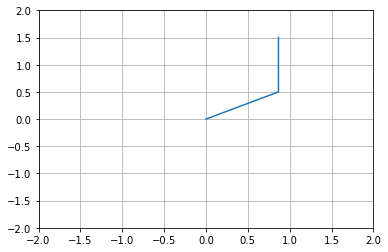

In [3]:
class arm():
    def __init__(self):
        self.x0 = 0
        self.y0 = 0
        self.l = 1
        self.O2 = np.array([[self.l,0]])
        self.theta1 = 30*(np.pi/180)
        self.theta2 = 60*(np.pi/180)

    def Rmatrix(self,theta):
        return np.array([[np.cos(theta), -np.sin(theta)],
                        [np.sin(theta), np.cos(theta)]])
    
    def Hmatrix(self,theta,O=np.zeros((1,2))):
        Hmatrix = np.concatenate((self.Rmatrix(theta),O.T),axis=1)
        return np.concatenate((Hmatrix,np.array([[0,0,1]])),axis=0)

r1 = arm()
j1 = (r1.Hmatrix(r1.theta1)@np.array([[r1.l,0,1]]).T)[:2]
end_eff = (r1.Hmatrix(r1.theta1)@r1.Hmatrix(r1.theta2,r1.O2)@np.array([[r1.l,0,1]]).T)[:2]
arm_data = np.concatenate((np.array([[0,0]]).T,j1,end_eff),axis=1)
arm_data
plt.plot(arm_data[0],arm_data[1])
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.grid()
plt.show()

[0.  1.2 1.2 0. ]
[0.  1.2 1.2 0. ]
[0.  1.2 1.2 0. ]
[0.  1.2 1.2 0. ]
[0.  1.2 1.2 0. ]
[0.  1.2 1.2 0. ]


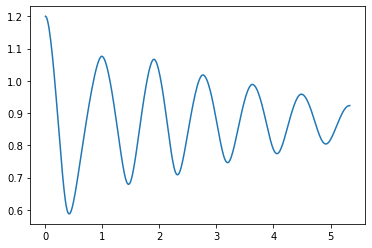

In [7]:
class Raiberthopper():
    def __init__(self):
        self.l0 = 1
        self.m = 1
        self.k = 100
        self.g = 9.8
        self.theta = 10*(np.pi/180)
        self.x0 = 0
        self.x0dot = np.array([1.2,1.2,1.2,1.2,1.2,1.2])
        self.y0 = 1.2
        self.y0dot = 0
        self.Xc = self.x0 + self.l0*np.sin(self.theta)
        self.z0 = np.array([self.x0,self.x0dot[0],self.y0,self.y0dot])
        self.Z = np.array([np.append(self.z0,self.Xc)])
        self.set_time()

    def set_time(self,t = 0):
        self.t0 = 0
        # self.tend = 3
        self.tpassed = t

    def set_z0(self,i):
        self.z0 = np.array([self.x0,self.x0dot[i],self.y0,self.y0dot])
        print(self.z0)

    
    def set_theta(self,xdot):
        Kp = 0.1
        self.theta = np.arcsin(((xdot * np.pi)/ (2* self.l0))*np.sqrt(self.m/self.k)) + Kp*(xdot - self.z0[1])
        return self.theta

    def get_Xc(self,x):
        return x + self.l0*np.sin(self.theta)
    
    def len_l(self,x,y):
        return np.sqrt(((x - self.Xc)**2 + y**2))
    
    def acelerations(self,t,z):

        x = z[0]
        y = z[2]
        
        xddot = (self.k/self.m)*(self.l0 - self.len_l(x,y)) * (x - self.Xc)/self.len_l(x,y)

        yddot = ((self.k/self.m)*(self.l0 - self.len_l(x,y)) * y/self.len_l(x,y)) - self.g

        zdot = np.array([z[1],xddot,z[3],yddot])

        return zdot
    
    def onestep(self,z,i):
        eq = ode(self.acelerations)
        self.Xc = self.get_Xc(z[0])
        # self.set_time(t)
        eq.set_initial_value(z,self.tpassed)
        dt = 0.01

        '''
        apex to stance phase 
        '''
        while eq.successful() and (eq.y[2] - self.l0*np.cos(self.theta) > 0):

            self.z = eq.integrate(eq.t+dt)
            self.Xc = self.get_Xc(self.z[0])
            z_temp = np.append(self.z,self.Xc)
            self.Z = np.append(self.Z,[z_temp],axis = 0)

        
        '''
        stance phase
        '''

        self.set_time(eq.t)
        eq.set_initial_value(self.Z[-1][0:4],self.tpassed)

        while eq.successful() and (self.l0 - self.len_l(eq.y[0],eq.y[2]) > 0):
            self.z = eq.integrate(eq.t+dt)
            z_temp = np.append(self.z,self.Xc)
            
            self.Z = np.append(self.Z,[z_temp],axis = 0)
        
        '''
        ground to apex
        '''

        self.set_time(eq.t)
        eq.set_initial_value(self.Z[-1][0:4],self.tpassed)

        while eq.successful() and (eq.y[3] > 0):
            # print(eq.y[3])
            self.z = eq.integrate(eq.t+dt)
            # self.Xc = self.get_Xc(self.z[0])
            z_temp = np.append(self.z,self.Xc)

            self.Z = np.append(self.Z,[z_temp],axis = 0)
        # print(self.Z)
        self.set_time(eq.t)
        self.set_z0(i)
        self.set_theta(self.Z[-1][1])
    
    def do_hopping(self,steps):
        self.set_time(0)
        self.onestep(self.z0,0)
        for i in range(1,steps):
            
            self.onestep(self.Z[-1][0:4],i)
        

h1 = Raiberthopper()
h1.do_hopping(steps=6)
t = np.linspace(1,len(h1.Z),len(h1.Z))

plt.plot(h1.Z[:,0],h1.Z[:,2])
# plt.plot(t,h1.Z[:,3])
# plt.plot(t,h1.Z[:,4])
# plt.plot(t,h1.Z[:,1])
# plt.plot(t,np.array([0 for i in range(len(t))]))
# plt.xlim(0,6)
# plt.ylim(0,1.3)
plt.show() 


In [13]:
class save_animation(Raiberthopper):
    def __init__(self,x,y,xc):
        super().__init__()
        self.X = x
        self.Y = y
        self.Xc = xc
        self.fig = plt.figure() 
        self.axis = plt.axes(xlim = (-5, 6),
                            ylim = (-0.1, 2)) 
        self.point, = self.axis.plot(0,0, marker='o') 
        self.line, = self.axis.plot([],[], lw = 2)
    
    def init(self): 
        self.point.set_data([],[]) 
        self.line.set_data([],[])
        return self.point, self.line,

    def animate(self,i):

        self.point.set_data(self.X[i], self.Y[i]) 
        Yc = ( self.Y[i]- self.l0*np.cos(self.theta)) if (self.Y[i]- self.l0*np.cos(self.theta) > 0) else 0
        
        self.line.set_data([self.X[i], self.Xc[i]], [self.Y[i],Yc]) 

        return self.point, self.line,

    def save(self,file_name = 'results/raiberthopper.mp4'):
        anim = animation.FuncAnimation(self.fig, self.animate, init_func = self.init, 
                               frames = len(self.X), interval = 20, blit = True) 
        anim.save(file_name, writer = 'ffmpeg', fps = 40)

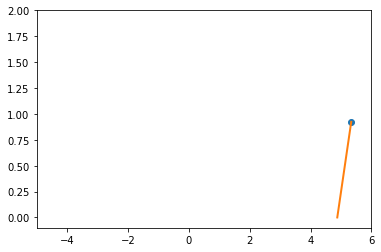

In [14]:
s2 = save_animation(h1.Z[:,0], h1.Z[:,2],h1.Z[:,4])
s2.save()